<a href="https://colab.research.google.com/github/MiguelCarbo/Anomalies-Detection-TFG/blob/main/1_Anomalies_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Reset Variables
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
#@title - Imports Adicionales -
#from google.colab import files
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from tabulate import tabulate
from sklearn.tree import plot_tree, export_graphviz
import graphviz 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_classif
import plotly.express as px
import glob
import json

In [ ]:
#@title - Imports Básicos - 
# Python Outlier Detection + Zeek Analysis Tool
!pip install pyod
!pip install zat

# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD
from pyod.models.gmm import GMM


# Local Imports
import zat;
from zat.log_to_dataframe import LogToDataFrame;
from zat.dataframe_to_matrix import DataFrameToMatrix;

# Packet Imports
import pandas as pd;
import numpy as np;
import sklearn;
from sklearn.ensemble import IsolationForest;
from sklearn.decomposition import PCA;
from sklearn.cluster import KMeans, DBSCAN;
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Version Printing
print('zat: {:s}'.format(zat.__version__))
print('Pandas: {:s}'.format(pd.__version__))
print('Numpy: {:s}'.format(np.__version__))
print('Scikit Learn Version:', sklearn.__version__)
# print('PYOD Version: {:s}'.format(pyod.__version__))

### 1. DATAFRAME CREATION FROM ZEEK LOG ###

In [ ]:
# Create a Pandas dataframe from the Zeek log
log_to_df = LogToDataFrame();
conn_df = log_to_df.create_dataframe('shuffled_logs.log');
print('Read in {:d} Rows...'.format(len(conn_df)))
conn_df.columns;

Read in 56375 Rows...


### 2. FEATURE SELECTION ###

In [ ]:
full_features = ['sourceAddress', 'sourcePort', 'destinationAddress', 'destinationPort', 'uid', 'protocol', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents',
        'mediaOrigen', 'mediaResp','desvOrigen', 'desvResp', 'noceroOrigen', 'noceroResp', 'mediaTime', 'desvTime']

features = ['service', 'duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 
        'mediaOrigen', 'mediaResp','desvOrigen', 'desvResp', 'noceroOrigen', 'noceroResp', 'mediaTime', 'desvTime']

### 3. DATA PREPARATION ###

#### 3.1 DATA CLEANSING ####

In [ ]:
# Feature Filtering + NaNs removal
conn_df = conn_df[full_features]
conn_df = conn_df.dropna()
conn_features_df = conn_df[features]

In [ ]:
for feature in features:
    if (conn_features_df[feature].dtype.name == 'category') and ('0' not in conn_features_df[feature].cat.categories):
        conn_features_df[feature] = conn_features_df[feature].cat.add_categories(['0'])
        conn_features_df[feature] = conn_features_df[feature].fillna('0')
    elif pd.api.types.is_timedelta64_dtype(conn_features_df[feature]): 
        conn_features_df[feature] = conn_features_df[feature].fillna(pd.Timedelta(0))
        conn_features_df[feature] = conn_features_df[feature].dt.total_seconds().astype(int)
    else: 
        conn_features_df[feature] = conn_features_df[feature].fillna(0)

<ipython-input-5-db2f7a8c0ce5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conn_features_df[feature] = conn_features_df[feature].cat.add_categories(['0'])
<ipython-input-5-db2f7a8c0ce5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conn_features_df[feature] = conn_features_df[feature].fillna('0')
<ipython-input-5-db2f7a8c0ce5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### 3.2 LABEL ENCODING ####

In [ ]:
# Relevant Considerations
# -- The ABOD (Angle-based Outlier Detection) algorithm is a distance-based outlier 
# -- detection algorithm that measures the angles between points in a high-dimensional space to detect outliers. 

# -- As a distance-based algorithm, it requires that all input features be numeric, as it relies on computing distances between points in the feature space.
# -- If your data contains non-numeric features, such as string values in some columns, then the ABOD algorithm will not be able to compute distances correctly 
# -- and will not be able to fit the data. This is normal behavior for distance-based algorithms like ABOD.

# -- To use the ABOD algorithm on your data, you will need to preprocess your data to convert the string features into numeric ones. 
# -- There are several ways to do this, depending on the specific characteristics of your data. One common approach is to use one-hot encoding or 
# -- label encoding to convert categorical features into numerical features that can be used by the algorithm.

# -- Alternatively, you may consider using a different outlier detection algorithm that can handle mixed data types, 
# -- such as the Isolation Forest algorithm or the Local Outlier Factor algorithm. These algorithms can handle both numeric and categorical features, 
# -- and can be used on mixed data types without requiring feature preprocessing.

In [ ]:
# LabelEncoding
# -- Another option might be using OneHotEncoding
le = LabelEncoder()
for feature in features:
    if (conn_features_df[feature].dtype.name == 'category') :
        print(feature)
        conn_features_df[feature] = le.fit_transform(conn_features_df[feature])

service


<ipython-input-6-e5b73d112ffd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for feature in features:


#### 3.3 NUMPY ARRAY CREATION ####

In [ ]:
# Dataframe conversion to float 
# - Necesario para operaciones posteriores
conn_features_df = conn_features_df.astype(float)

# Convert the dataframe to a numpy array
X = conn_features_df.to_numpy()
print(X.shape)

(48516, 16)


### 4. CLASSIFICATION ALGORITHMS ###

In [ ]:
# Random State 42
# -- In NumPy, the random_state parameter is used to set the seed for the 
# -- random number generator, which determines the sequence of random numbers 
# -- generated by NumPy's random functions.

# -- When you set random_state to a fixed value, you get a reproducible sequence 
# -- of random numbers every time you run your code. 
# -- This can be useful when you need to compare results across multiple runs 
# -- or when you want to ensure that the random numbers are the same each time you run your code.

# -- In the case of random_state=42, the number 42 is an arbitrary value that 
# -- is commonly used as a default seed in many programming examples and tutorials.

rs = np.random.RandomState(42)

# Outlier detectetion algorithms
clf = {
    # 'Angle-based Outlier Detector (ABOD)': ABOD(contamination=0.1),
    'Cluster-based Local Outlier Factor (CBLOF)': CBLOF(contamination=0.1, check_estimator=False, random_state=rs),
    'Isolation Forest': IForest(contamination=0.04, random_state=rs),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.1),
    # 'Average KNN': KNN(method='mean', contamination=0.1),
    'Local Outlier Factor (LOF)': LOF(n_neighbors=50, contamination=0.1),
    'Copula Based Outlier Detector (COPOD)': COPOD(contamination=0.04),
    'Emipirical-Cumulative-Distribution-based Outlier Detector (ECOD)': ECOD(contamination=0.04),
    'One-class SVM (OCSVM)': OCSVM(contamination=0.1),
    'Gaussian Mixture Model (GMM)': GMM(contamination=0.1,random_state=rs),
    # 'Principal Component Analysis (PCA)': PCA(),
}

In [ ]:
# Show all detectors
for i, classifier in enumerate(clf.keys()):
    print('Model', i + 1, classifier)

### 5. MODEL FITTING - TRAINING - PREDICTION ###

In [ ]:
clusters_separation = [0]
clf_names = list(clf.keys())
outliers_pred = np.zeros((X.shape[0], len(clf_names)))

# Fit the models with the generated data and compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)

    # Fit the model
    for i, (classifier_name, classifier) in enumerate(clf.items()):

        print(i + 1, 'fitting', classifier_name)

        # Fit the data and tag outliers
        classifier.fit(X)

        # Scores prediction
        scores_pred = classifier.decision_function(X) * -1
        
        # Outliers detection (based on prediction)
        y_pred = classifier.predict(X)
        outliers_pred[:,i] = y_pred;

1 fitting Cluster-based Local Outlier Factor (CBLOF)


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:856: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  def _check_params_vs_input(self, X, default_n_init=None):


2 fitting Isolation Forest
3 fitting K Nearest Neighbors (KNN)
4 fitting Local Outlier Factor (LOF)
5 fitting Copula Based Outlier Detector (COPOD)
6 fitting Emipirical-Cumulative-Distribution-based Outlier Detector (ECOD)
7 fitting One-class SVM (OCSVM)
8 fitting Gaussian Mixture Model (GMM)


### 6. RESULT ANALYSIS ###

In [ ]:
for i in range(len(clf_names)):
    ones = np.where(outliers_pred[:,i] == 1)
    print(ones)

(array([    4,    11,    20, ..., 48460, 48461, 48474]),)
(array([   12,    23,    66, ..., 48427, 48437, 48457]),)
(array([    1,    12,    18, ..., 48464, 48499, 48515]),)
(array([    2,    15,    32, ..., 48494, 48508, 48509]),)
(array([   12,    23,    55, ..., 48457, 48464, 48499]),)
(array([   12,    23,    68, ..., 48457, 48460, 48499]),)
(array([  334,  3692,  7722, 12128, 16319, 20120, 20360, 21299, 21390,
       22356, 23694, 23843, 24303, 25557, 25568, 25846, 26924, 27153,
       27969, 28113, 28402, 29197, 32227, 33278, 34237, 34770, 34800,
       37446, 37678, 37688, 39826, 41860, 41867, 43103, 43139, 43459,
       43847, 44186, 44341, 44467, 45353, 46242, 46360, 46893, 47471,
       48419]),)
(array([   12,    23,    26, ..., 48499, 48506, 48512]),)


### 6.1 OUTLIERS DATAFRAMES ###

In [ ]:
# Dataframe etiquetado según el Script creado

# - Este archivo ha sido etiquetado de forma correcta 
labeled_conn_df = log_to_df.create_dataframe('shuffled_logs.log');
# Se mantienen solo conexiones malignas
malign_conn_df = labeled_conn_df[labeled_conn_df['label'] == 'MALIGN'];
malign_conn_df = malign_conn_df[full_features]
malign_conn_df = malign_conn_df.dropna()

# Obtencion de indicadores de conexiones 
malign_conn_uid_values = malign_conn_df['uid'].unique()
# malign_conn_df['flow_id'] = malign_conn_df['protocol'].astype(str) + malign_conn_df['sourceAddress'].astype(str) + malign_conn_df['destinationAddress'].astype(str) + malign_conn_df['sourcePort'].astype(str) + malign_conn_df['destinationPort'].astype(str)

### 7. RESULT ANALYSIS ###

In [ ]:
# Odd-Dataframes List
odd_dfs_list = []

# Comprobacion de los resultados con cada algoritmo
for j in range(len(clf_names)):
    
    # Algoritmo utilizado
    print(' -- ' + str(clf_names[j]) + ' --')

    # Nuevo dataframe anomalo
    odd_out_df = pd.DataFrame()
    for i in range(outliers_pred.shape[0]):
        # Deteccion de trafico anomalo
        if outliers_pred[i,j] == 1:
            odd_out_df = odd_out_df.append(conn_df.iloc[i])
            
    # Ajuste de tipo de dato
    odd_out_df['sourcePort'] = np.uint16(odd_out_df['sourcePort'])
    odd_out_df['destinationPort'] = np.uint16(odd_out_df['destinationPort'])
    # Guardamos el Dataframe para trabajar con este mas tarde
    odd_dfs_list.append(odd_out_df)
    # Identificacion por UID unico de cada flujo
    odd_uid_values = odd_out_df['uid'].unique()

    # Comprobacion coincidencia Anomalo - Maligno
    print('Analyzing results from labeled log ...')
    detected_positives = 0
    for uid in odd_uid_values:
        # Check if the concatenated value is in the list of ip_src_dest values
        if uid in malign_conn_uid_values:
            detected_positives+=1
    print('     Detected Positives:', detected_positives)
    print('     False Positives: ', len(odd_uid_values) - detected_positives)
    print('     Undetected Malign:', len(malign_conn_uid_values) - detected_positives)
    print(' ')


 -- Cluster-based Local Outlier Factor (CBLOF) --
Analyzing results from labeled log ...
     Detected Positives: 81
     False Positives:  4728
     Undetected Malign: 2460
 
 -- Isolation Forest --
Analyzing results from labeled log ...
     Detected Positives: 45
     False Positives:  1896
     Undetected Malign: 2496
 
 -- K Nearest Neighbors (KNN) --
Analyzing results from labeled log ...
     Detected Positives: 84
     False Positives:  4651
     Undetected Malign: 2457
 
 -- Local Outlier Factor (LOF) --
Analyzing results from labeled log ...
     Detected Positives: 54
     False Positives:  4645
     Undetected Malign: 2487
 
 -- Copula Based Outlier Detector (COPOD) --
Analyzing results from labeled log ...
     Detected Positives: 10
     False Positives:  1931
     Undetected Malign: 2531
 
 -- Emipirical-Cumulative-Distribution-based Outlier Detector (ECOD) --
Analyzing results from labeled log ...
     Detected Positives: 28
     False Positives:  1913
     Undetected M

#### 7.A FROM ORIGINAL CSV ####

In [ ]:
# NOTA: esta fuente no debe ser tomada como referencia fiable puesto que los flujos
# del archivo CSV han sido etiquetados de forma errónea; se utiliza solo como una 
# medida temporal de orientación

# Original Source with Labeled Data
original_df = pd.read_csv('Tuesday-WorkingHours.pcap_ISCX.csv')
print(original_df.columns)

# Eliminamos todas las filas que tengan la columna de Benign
malign_original_df = original_df.drop(original_df[original_df[' Label'] == 'BENIGN'].index)

# Formateo del Dataframe
if (' Source IP' and ' Destination IP' and ' Source Port' and ' Destination Port') in original_df.columns:
    malign_original_df = malign_original_df.rename(columns={' Protocol': 'protocol'})
    malign_original_df = malign_original_df.rename(columns={' Source IP': 'sourceAddress'})
    malign_original_df = malign_original_df.rename(columns={' Destination IP': 'destinationAddress'})
    malign_original_df = malign_original_df.rename(columns={' Source Port': 'sourcePort'})
    malign_original_df = malign_original_df.rename(columns={' Destination Port': 'destinationPort'})

# Ajustamos los valores de la columna 'protocol'
mask_6 = malign_original_df['protocol'] == 6
mask_17 = malign_original_df['protocol'] == 17
malign_original_df.loc[mask_6, 'protocol'] = 'tcp'
malign_original_df.loc[mask_17, 'protocol'] = 'udp'

# Obtenemos los flujos malignos identificados de forma única
malign_original_df['flow_id'] = malign_original_df['protocol'].astype(str) + malign_original_df['sourceAddress'].astype(str) + malign_original_df['destinationAddress'].astype(str) + malign_original_df['sourcePort'].astype(str) + malign_original_df['destinationPort'].astype(str)
malign_flow_id_values = malign_original_df['flow_id'].unique()


In [ ]:
# Positive Detection
detected_positives = 0

# Analizamos para cada algoritmo los resultados obtenidos
for i in range (0, len(clf_names)):
    if i == 0:
        for flow_id in IFOREST_flow_id_values:
            # Check if the concatenated value is in the list of ip_src_dest values
            if flow_id in malign_flow_id_values:
                detected_positives+=1
        print('- IFOREST Results -')
        print('Detected Positives:', detected_positives)
        print('False Positives: ', len(IFOREST_flow_id_values) - detected_positives)
        print('Undetected Malign:', len(malign_flow_id_values) - detected_positives)
    if i == 1:
        for flow_id in COPOD_flow_id_values:
            # Check if the concatenated value is in the list of ip_src_dest values
            if flow_id in malign_flow_id_values:
                detected_positives+=1
        print('- COPOD Results -')
        print('Detected Positives:', detected_positives)
        print('False Positives: ', len(COPOD_flow_id_values) - detected_positives)
        print('Undetected Malign:', len(malign_flow_id_values) - detected_positives)
    if i == 2:
        for flow_id in ECOD_flow_id_values:
            # Check if the concatenated value is in the list of ip_src_dest values
            if flow_id in malign_flow_id_values:
                detected_positives+=1
        print('- ECOD Results -')
        print('Detected Positives:', detected_positives)
        print('False Positives: ', len(ECOD_flow_id_values) - detected_positives)
        print('Undetected Malign:', len(malign_flow_id_values) - detected_positives)


- IFOREST Results -
Detected Positives: 47
False Positives:  29476
Undetected Malign: 6923
- COPOD Results -
Detected Positives: 202
False Positives:  29164
Undetected Malign: 6768
- ECOD Results -
Detected Positives: 2045
False Positives:  27265
Undetected Malign: 4925


### 8. PROJECTIONS ###

#### 8.0 Dataframe Reload (optional) ####

In [ ]:
# Create a Pandas dataframe from the Zeek log
log_to_df = LogToDataFrame();
conn_df = log_to_df.create_dataframe('shuffled_logs.log');
print('Read in {:d} Rows...'.format(len(conn_df)))
conn_df.columns

full_features = ['sourceAddress', 'sourcePort', 'destinationAddress', 'destinationPort', 'uid', 'protocol', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents',
        'mediaOrigen', 'mediaResp','desvOrigen', 'desvResp', 'noceroOrigen', 'noceroResp', 'mediaTime', 'desvTime']

features = ['service', 'duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 
        'mediaOrigen', 'mediaResp','desvOrigen', 'desvResp', 'noceroOrigen', 'noceroResp', 'mediaTime', 'desvTime']

# Feature Filtering + NaNs removal
conn_df = conn_df[full_features]
conn_df = conn_df.dropna()

conn_features_df = conn_df[features]

for feature in features:
    if (conn_features_df[feature].dtype.name == 'category') and ('0' not in conn_features_df[feature].cat.categories):
        conn_features_df[feature] = conn_features_df[feature].cat.add_categories(['0'])
        conn_features_df[feature] = conn_features_df[feature].fillna('0')
    elif pd.api.types.is_timedelta64_dtype(conn_features_df[feature]): 
        conn_features_df[feature] = conn_features_df[feature].fillna(pd.Timedelta(0))
        conn_features_df[feature] = conn_features_df[feature].dt.total_seconds().astype(int)
    else: 
        conn_features_df[feature] = conn_features_df[feature].fillna(0)

# LabelEncoding
# -- Another option might be using OneHotEncoding
le = LabelEncoder()
for feature in features:
    if (conn_features_df[feature].dtype.name == 'category') :
        print(feature)
        conn_features_df[feature] = le.fit_transform(conn_features_df[feature])
        
conn_features_df = conn_features_df.astype(float)

X = conn_features_df.to_numpy()
y = conn_df['uid']

#### 8.1 TSNE Projection ####

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


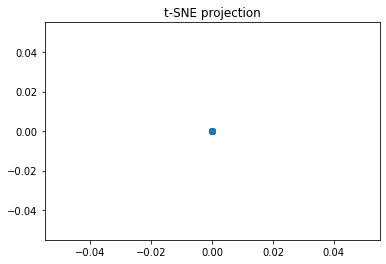

In [ ]:
# Initialize the t-SNE algorithm with the desired parameters
tsne = TSNE(n_components=2, random_state=42)

# Apply t-SNE to the features
X_tsne = tsne.fit_transform(X)

# Visualize the t-SNE projection in a scatter plot
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE projection')
plt.show()

#### 8.2 PCA Projection ####

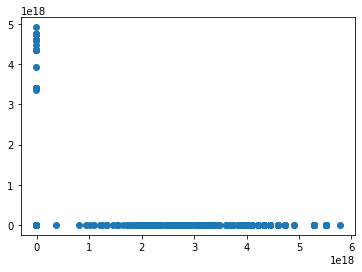

In [ ]:
from sklearn.decomposition import PCA

# create a PCA object with 2 components
pca_object = PCA(n_components=2)

# obtain the 2-dimensional PCA representation of X
X_pca = pca_object.fit_transform(X)

# plot the PCA representation in a scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

#### 8.3 UMAP Projection ####

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


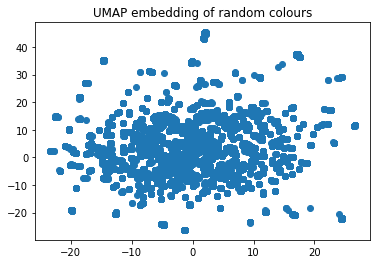

In [ ]:
# UMAP
!pip install umap-learn

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from umap.umap_ import UMAP

fit = UMAP(metric='euclidean', n_neighbors=500, n_components=2)
X_umap = fit.fit_transform(X)

plt.scatter(X_umap[:,0], X_umap[:,1])
plt.title('UMAP embedding of random colours');

### 9.CLUSTERING OPTIONS ###

#### 9.1 MALIGN TRAFFIC ####

In [ ]:
# Malign Traffic Matrix
to_matrix = DataFrameToMatrix();
malign_conn_feature_matrix = to_matrix.fit_transform(malign_conn_df[features], normalize=True);

# Ajustamos con DBScan
malign_conn_df['cluster_db'] = DBSCAN().fit_predict(malign_conn_feature_matrix)
print('Number of Clusters: {:d}'.format(malign_conn_df['cluster_db'].nunique()))

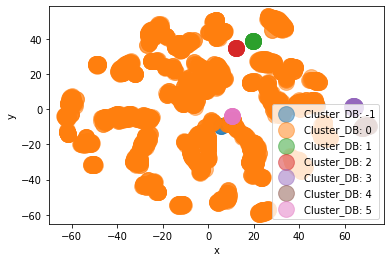

In [ ]:
import matplotlib.colors as mcolors

# Now use dataframe group by cluster
malign_cluster_groups_db = malign_conn_df.groupby('cluster_db')

# Projection using TSNE or PCA algorithm
malign_projection = TSNE().fit_transform(malign_conn_feature_matrix);
malign_conn_df['x'] = malign_projection[:, 0]; # Projection X Column
malign_conn_df['y'] = malign_projection[:, 1]; # Projection Y Column

# Get a list of colors
k = 0
colors = list(mcolors.TABLEAU_COLORS.values())
ncolors = malign_conn_df['cluster_db'].nunique()
# Create a dictionary of colors
color_dict = {f"{k-1}": color for k, color in enumerate(colors[:ncolors])}

# Plot the Machine Learning results
fig, ax = plt.subplots()
for key, group in malign_cluster_groups_db:
    group.plot(ax=ax, kind='scatter', x='x', y='y', alpha=0.5, s=250,
               label='Cluster_DB: {:d}'.format(key), color=str(color_dict.get(str(key))))

In [ ]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in malign_cluster_groups_db:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())

#### 9.2 DETECTED ANOMALOUS TRAFFIC ####

Changing column service to category...
Normalizing column duration...
Normalizing column orig_bytes...
Normalizing column resp_bytes...
Normalizing column orig_pkts...
Normalizing column orig_ip_bytes...
Normalizing column resp_pkts...
Normalizing column resp_ip_bytes...
Normalizing column mediaOrigen...
Normalizing column mediaResp...
Normalizing column desvOrigen...
Normalizing column desvResp...
Normalizing column noceroOrigen...
Normalizing column noceroResp...
Normalizing column mediaTime...
Normalizing column desvTime...
Cluster-based Local Outlier Factor (CBLOF)
-- Number of Clusters: 11

Cluster -1: 12 observations
                     service               duration    orig_bytes  resp_bytes  orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes   mediaOrigen   mediaResp    desvOrigen     desvResp  noceroOrigen  noceroResp  mediaTime   desvTime
2017-07-06 18:08:11  dce_rpc 0 days 00:00:00.000740  1.680000e+02        24.0       10.0          760.0        8.0          392.0  1.02481

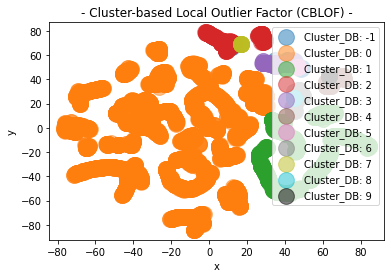

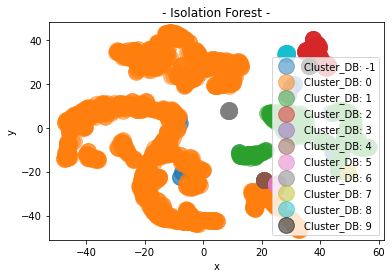

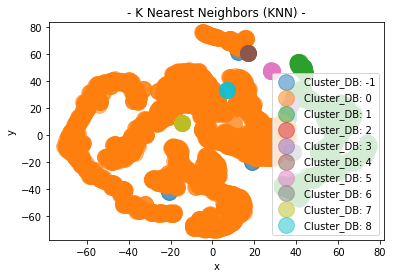

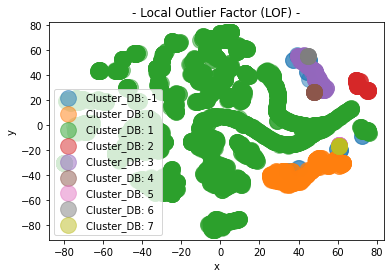

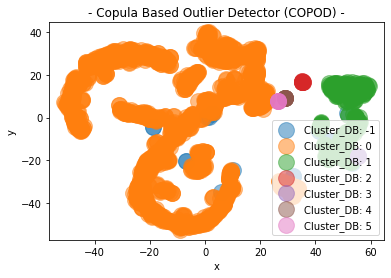

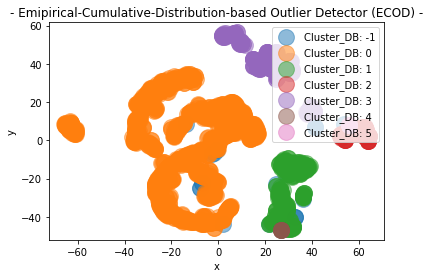

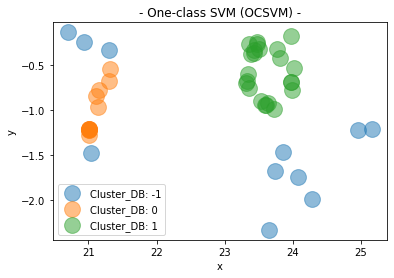

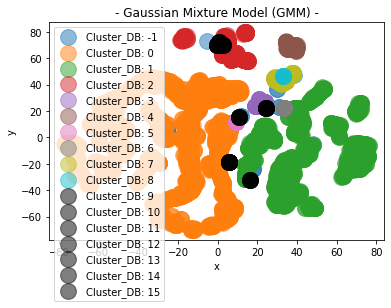

In [ ]:
import matplotlib.colors as mcolors

# Malign Traffic Matrix
to_matrix = DataFrameToMatrix();
colors = list(mcolors.TABLEAU_COLORS.values())

# Now try DBScan
for i in range(len(clf_names)):
    # Odd Dataframe extraction
    odd_df = odd_dfs_list[i]
    odd_feature_matrix = to_matrix.fit_transform(odd_df[features], normalize=True);
    # Odd Dataframe Clustering
    odd_df['cluster_db'] = DBSCAN().fit_predict(odd_feature_matrix);
    print(str(clf_names[i]))
    print('-- Number of Clusters: {:d}'.format(odd_df['cluster_db'].nunique()))

    # Now use dataframe group by cluster
    odd_cluster_groups_db = odd_df.groupby('cluster_db')    
    # Projection using TSNE or PCA algorithm
    projection = TSNE().fit_transform(odd_feature_matrix);
    odd_df['x'] = projection[:, 0]; # Projection X Column
    odd_df['y'] = projection[:, 1]; # Projection Y Column

    # Get a list of colors
    k = 0
    ncolors = odd_df['cluster_db'].nunique()
    # Create a dictionary of colors
    color_dict = {f"{k-1}": color for k, color in enumerate(colors[:ncolors])}

    # Plot the Machine Learning results
    fig, ax = plt.subplots()
    for key, group in odd_cluster_groups_db:
        plt.title('- ' + str(clf_names[i]) + ' -') 
        group.plot(ax=ax, kind='scatter', x='x', y='y', alpha=0.5, s=250,
                label='Cluster_DB: {:d}'.format(key), color=str(color_dict.get(str(key))))
    
    # Now print out the details for each cluster
    pd.set_option('display.width', 1000)
    for key, group in odd_cluster_groups_db:
        print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
        print(group[features].head())